# Portfolio Analysis

## Packages

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from   tqdm import tqdm

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
tqdm.pandas()

In [3]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FallenAngel\root\src")
from SignalGenerator import SignalGenerator
from SignalConsistancy import SignalConsistancy

## Duration Exposure

In [4]:
def get_signal() -> pd.DataFrame: 
    
    df_oos = (SignalConsistancy().get_expanding_ols().query(
        "window == 10 & rtn_group == 'dollar_neutral'"))

    df_os_signal = (df_oos.assign(
        sample = "oos",
        signal = lambda x: np.sign(x.lag_zscore) * x.lag_beta).
        query("rtn_group == 'dollar_neutral'")
        [["date", "variable", "rtn_group", "ticker_spread", "signal", "sample"]])

    df_is_signal = (SignalGenerator().get_signal().query(
        "rtn_group == 'dollar_neutral'")
        [["date", "variable", "lag_zscore", "rtn_group", "ticker_spread"]].
        rename(columns = {"lag_zscore": "signal"}).
        assign(sample = "is"))

    df_signal = (pd.concat(
        [df_os_signal, df_is_signal]).
        assign(date = lambda x: pd.to_datetime(x.date)))
    
    return df_signal

df_signal = get_signal()

In [5]:
def get_dollar_neutral_dur() -> pd.DataFrame: 

    df_hy = (SignalGenerator().get_bond_data().query(
        "security != ['LQD', 'AGG', 'FALN', 'ANGL']")
        [["date", "security", "MOD_DUR"]].
        rename(columns = {
            "security": "hy_ticker",
            "MOD_DUR" : "hy_dur"}))

    df_angl = (SignalGenerator().get_bond_data().query(
        "security == ['ANGL', 'FALN']")
        [["date", "security", "MOD_DUR"]].
        rename(columns = {
            "security": "angl_ticker",
            "MOD_DUR" : "angl_dur"}))

    df_dur_spread = (df_hy.merge(
        right = df_angl, how = "inner", on = ["date"]).
        assign(
            date          = lambda x: pd.to_datetime(x.date),
            dur_spread    = lambda x: x.angl_dur - x.hy_dur,
            ticker_spread = lambda x: x.angl_ticker + "_" + x.hy_ticker)
        [["date", "ticker_spread", "dur_spread"]])
    
    return df_dur_spread

df_dur_spread = get_dollar_neutral_dur()

In [6]:
def get_dur_pos(df_signal: pd.DataFrame, df_dur_spread: pd.DataFrame) -> pd.DataFrame: 
    
    df_dur_pos = (df_signal.merge(
        right = df_dur_spread, how = "inner", on = ["date", "ticker_spread"]).
        assign(dur_pos = lambda x: np.sign(x.signal) * x.dur_spread).
        groupby(["date", "variable", "rtn_group", "ticker_spread", "sample"]).
        agg("mean").
        reset_index().
        drop(columns = ["rtn_group"])
        [["date", "variable", "sample", "dur_pos"]].
        groupby(["date", "variable", "sample"]).
        agg("mean").
        reset_index().
        rename(columns = {"sample": "sample_group"}))
    
    return df_dur_pos

df_dur_pos = get_dur_pos(df_signal, df_dur_spread)

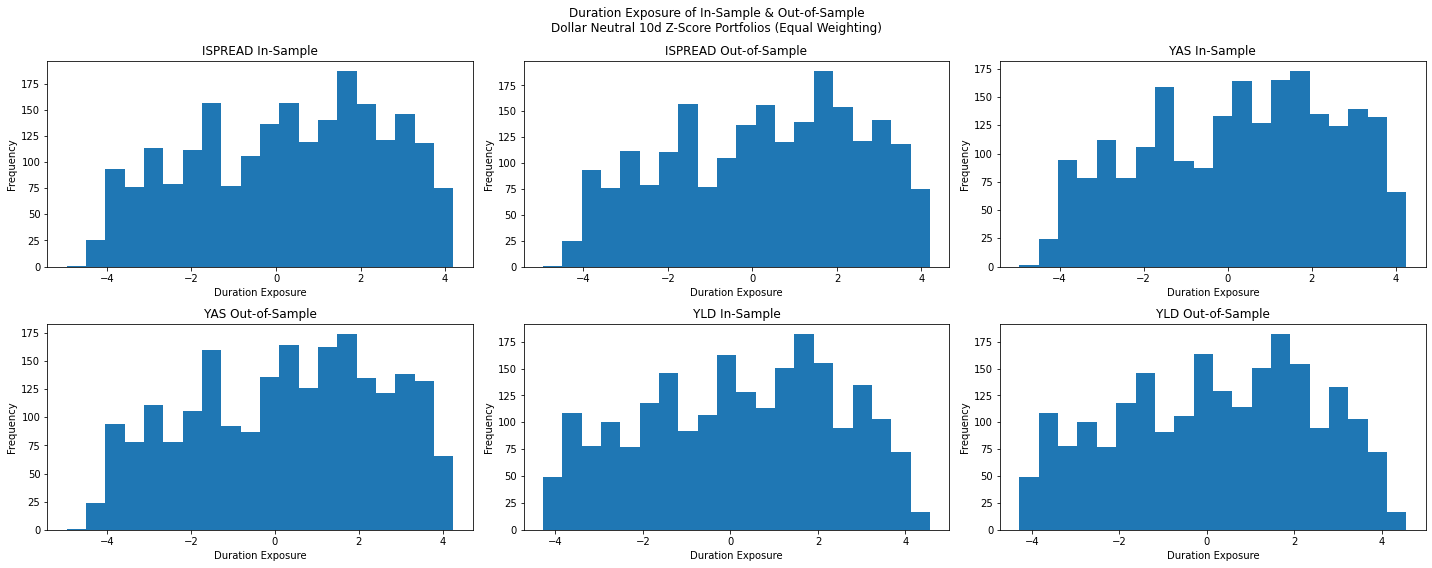

In [7]:
def plot_dur_hist(df_dur_pos: pd.DataFrame) -> plt.Figure: 
    
    df_plot   = (df_dur_pos.assign(
        sample_group = lambda x: np.where(x.sample_group == "is", "In-Sample", "Out-of-Sample"),
        group_var   = lambda x: x.variable + " " + x.sample_group))
    
    variables = df_plot.group_var.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 3, figsize = (20,8))

    for variable, ax in zip(variables, axes.flatten()):

        (df_plot.query(
            "group_var == @variable").
            dur_pos.
            plot(
                kind   = "hist", 
                bins   = 20,
                ax     = ax,
                title  = variable,
                xlabel = "Duration Exposure"))

    fig.suptitle("Duration Exposure of In-Sample & Out-of-Sample\nDollar Neutral 10d Z-Score Portfolios (Equal Weighting)")
    plt.tight_layout()
    
plot_dur_hist(df_dur_pos)

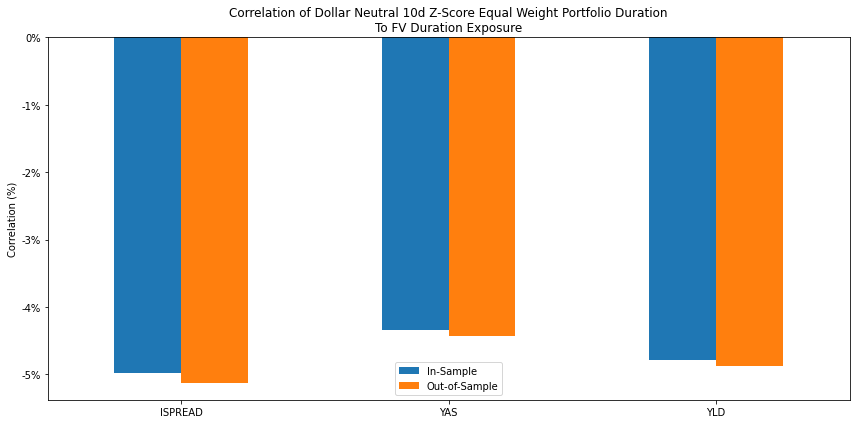

In [8]:
def plot_duration_correlation(df_dur_pos: pd.DataFrame) -> plt.Figure: 
    
    path    = r"C:\Users\Diego\Desktop\app_prod\BBGFuturesManager\data\BondDeliverableRisk\FV.parquet"
    renamer = {
        "is" : "In-Sample",
        "oos": "Out-of-Sample"}

    fig, axes = plt.subplots(figsize = (12,6))

    df_fv = (pd.read_parquet(
        path = path, engine = "pyarrow").
        query("variable == 'CONVENTIONAL_CTD_FORWARD_FRSK'").
        set_index("date")
        [["value"]])

    df_dur = (df_dur_pos.merge(
        right = df_fv, how = "inner", on = ["date"]).
        drop(columns = ["date"]).
        groupby(["variable", "sample_group"]).
        agg("corr")
        [["dur_pos"]].
        reset_index().
        query("level_2 == 'value'").
        drop(columns = ["level_2"]).
        rename(columns = {"sample_group": ""}).
        pivot(index = "variable", columns = "", values = "dur_pos").
        rename(columns = renamer))

    df_dur.plot(
        kind   = "bar",
        rot    = 0,
        xlabel = "",
        ylabel = "Correlation (%)",
        ax     = axes,
        title  = "Correlation of Dollar Neutral 10d Z-Score Equal Weight Portfolio Duration\nTo FV Duration Exposure")

    axes.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
    plt.tight_layout()
    
plot_duration_correlation(df_dur_pos)

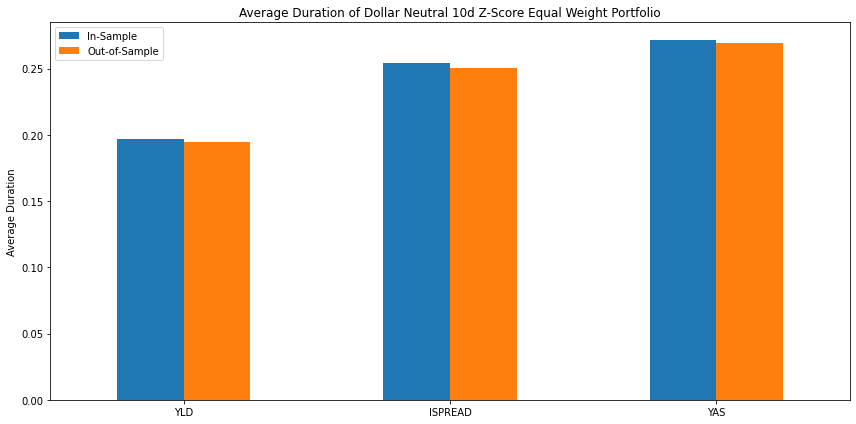

In [9]:
def plot_avg_dur(df_dur_pos: pd.DataFrame) -> plt.Figure: 
    
    (df_dur_pos.drop(
        columns = ["date"]).
        groupby(["variable", "sample_group"]).
        agg("mean").
        reset_index().
        rename(columns = {"sample_group": ""}).
        pivot(index = "variable", columns = "", values = "dur_pos").
        sort_values("is").
        rename(columns = {
            "is" : "In-Sample",
            "oos": "Out-of-Sample"}).
        plot(
            kind    = "bar",
            xlabel  = "",
            rot     = 0,
            ylabel  = "Average Duration",
            figsize = (12,6),
            title   = "Average Duration of Dollar Neutral 10d Z-Score Equal Weight Portfolio"))

    plt.tight_layout()
    
plot_avg_dur(df_dur_pos)

## Market Exposure

In [10]:
def get_signal() -> pd.DataFrame: 
    
    df_oos = (SignalConsistancy().get_expanding_ols().query(
        "window == 10 & rtn_group == 'dollar_neutral'"))

    df_os_signal = (df_oos.assign(
        sample = "oos",
        signal = lambda x: np.sign(x.lag_zscore) * x.lag_beta).
        query("rtn_group == 'dollar_neutral'")
        [["date", "variable", "rtn_group", "ticker_spread", "signal", "sample", "spread"]])

    df_is_signal = (SignalGenerator().get_signal().query(
        "rtn_group == 'dollar_neutral'")
        [["date", "variable", "lag_zscore", "rtn_group", "ticker_spread", "spread"]].
        rename(columns = {"lag_zscore": "signal"}).
        assign(sample = "is"))

    df_signal = (pd.concat(
        [df_os_signal, df_is_signal]).
        assign(date = lambda x: pd.to_datetime(x.date)))
    
    return df_signal

df_signal_rtn = get_signal()

In [11]:
def _get_param(df: pd.DataFrame) -> pd.DataFrame: 
    
    model = (sm.OLS(
        endog = df.signal_rtn,
        exog  = sm.add_constant(df.value)).
        fit())
    
    df_out = (model.params.to_frame(
        name = "val").
        reset_index().
        merge(
            right = model.pvalues.to_frame(name = "pval").reset_index(),
            how   = "inner",
            on    = ["index"]))
    
    return df_out

def _get_ols(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df.set_index(
        "date").
        sort_index()
        [["value", "signal_rtn"]])
    
    df_monthly = (df_tmp.apply(
        lambda x: np.cumprod(1 + x) - 1).
        apply(lambda x: x * 10_000_000).
        resample(rule = "1m").
        first().
        pct_change().
        dropna())

    df_combined = (pd.concat([
        df_tmp.assign(rtn_freq = "daily"),
        df_monthly.assign(rtn_freq = "monthly")]))
    
    df_out = (df_combined.groupby(
        "rtn_freq").
        apply(_get_param).
        reset_index().
        drop(columns = ["level_1"]))
    
    return df_out
    
def get_ols(df_signal_rtn: pd.DataFrame) -> pd.DataFrame: 

    df_port = (df_signal_rtn.assign(
        signal_rtn = lambda x: np.sign(x.signal) * x.spread).
        drop(columns = ["signal", "spread"]).
        drop(columns = ["ticker_spread"]).
        groupby(["date", "variable", "rtn_group", "sample"]).
        agg("mean").
        reset_index())

    df_ols = (SignalGenerator().get_raw_px().query(
        "security == ['LQD', 'AGG', 'JNK', 'ANGL']").
        pivot(index = "date", columns = "security", values = "PX").
        pct_change().
        reset_index().
        melt(id_vars = "date").
        dropna().
        assign(date = lambda x: pd.to_datetime(x.date)).
        merge(right = df_port, how = "inner", on = ["date"]).
        rename(columns = {"sample": "sample_group"}).
        groupby(["security", "variable", "rtn_group", "sample_group"]).
        apply(_get_ols).
        reset_index().
        drop(columns = ["level_4"]).
        rename(columns = {"index": "param_var"}))
    
    return df_ols

df_ols = get_ols(df_signal_rtn)

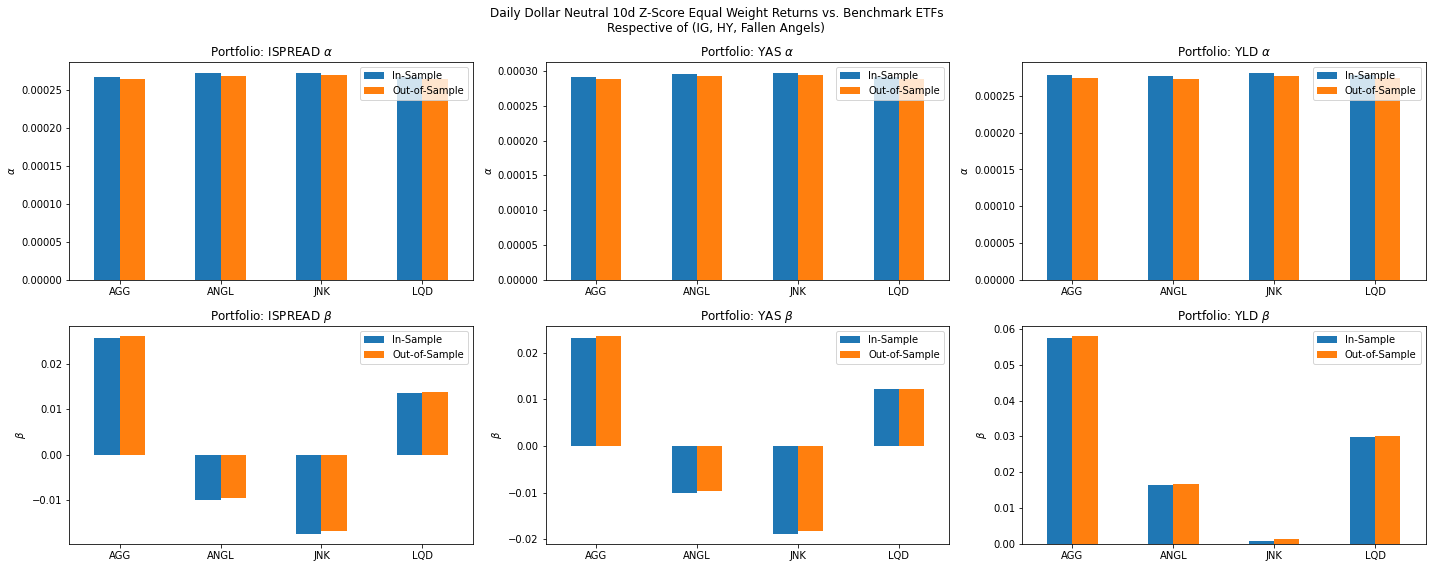

In [12]:
def plot_ols(df_ols: pd.DataFrame, rtn_freq: str = "daily") -> plt.Figure: 

    df_plot = (df_ols.assign(
        sample_group = lambda x: np.where(x.sample_group == "is", "In-Sample", "Out-of-Sample"),
        param_var    = lambda x: np.where(x.param_var == "const", r"$\alpha$", r"$\beta$"),
        group_var    = lambda x: "Portfolio: " + x.variable + " " + x.param_var).
        query("rtn_freq == @rtn_freq").
        sort_values(["param_var", "param_var"]))

    group_vars = df_plot.group_var.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_plot.query(
            "group_var == @group_var").
            rename(columns = {"sample_group": ""}).
            pivot(index = "security", columns = "", values = "val").
            plot(
                ax     = ax,
                kind   = "bar",
                ylabel = group_var.split(" ")[-1],
                title  = group_var,
                rot    = 0,
                xlabel = ""))

    fig.suptitle("{} Dollar Neutral 10d Z-Score Equal Weight Returns vs. Benchmark ETFs\nRespective of (IG, HY, Fallen Angels)".format(
        rtn_freq.capitalize()))
    plt.tight_layout()
    
plot_ols(df_ols, "daily")

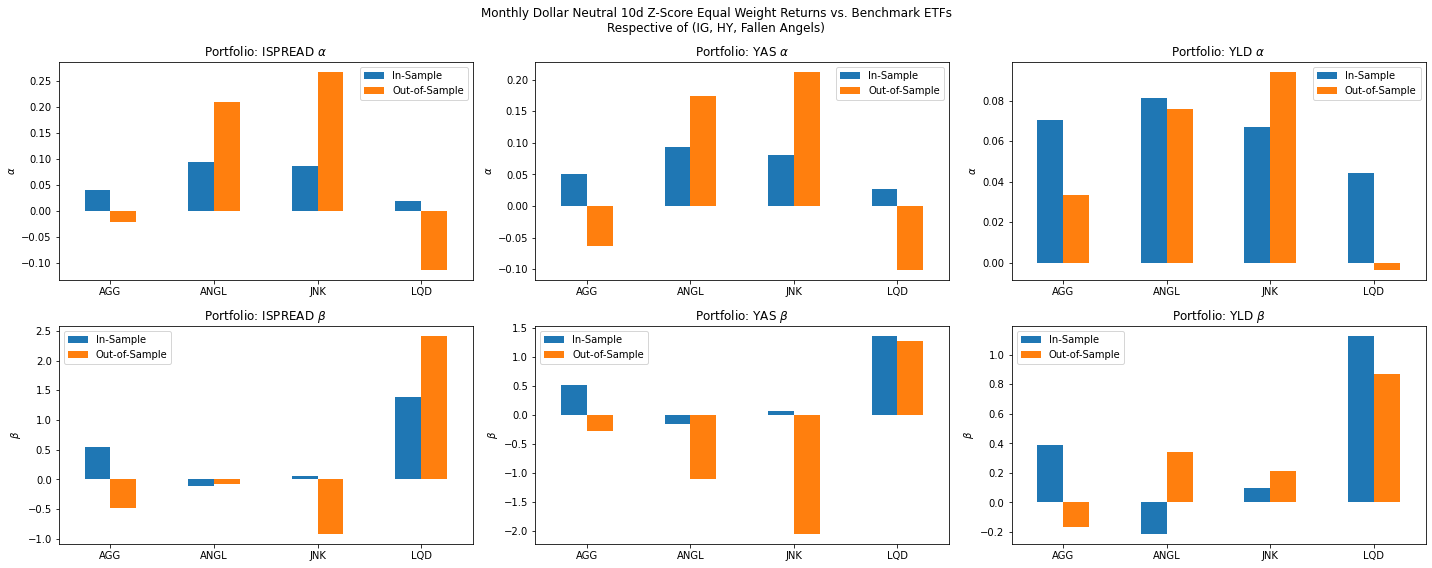

In [13]:
plot_ols(df_ols, "monthly")

## Signal Turnover

In [14]:
def _get_turnover(df: pd.DataFrame) -> pd.DataFrame:
    
    df_tmp = (df.sort_values(
        "date").
        assign(
            signal     = lambda x: np.sign(x.signal),
            lag_signal = lambda x: x.signal.shift()).
        query("signal != lag_signal").
        dropna())
    
    df_out = (df_tmp.assign(
        trade = ["trade{}".format(i + 1) for i in range(len(df_tmp))])
        [["date", "trade"]].
        merge(right = df, how = "outer", on = ["date"]).
        sort_values("date").
        sort_values("date").
        assign(trade = lambda x: x.trade.ffill())
        [["trade", "date"]].
        dropna().
        groupby("trade").
        agg("count").
        date.
        mean())
    
    return df_out

def get_average_turnover(df_signal: pd.DataFrame) -> pd.DataFrame:

    df_out = (df_signal.groupby(
        ["variable", "rtn_group", "ticker_spread", "sample"]).
        apply(_get_turnover).
        to_frame(name = "turnover").
        reset_index().
        drop(columns = ["rtn_group"]))
    
    return df_out

df_turnover = get_average_turnover(df_signal)

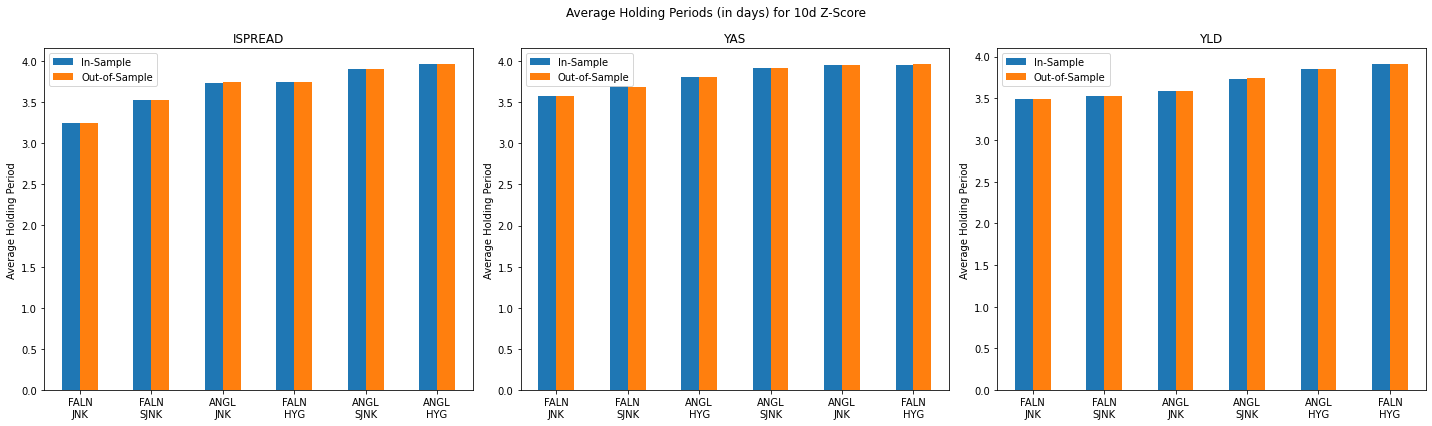

In [107]:
def plot_singal_turnover(df_turnover: pd.DataFrame) -> plt.Figure: 
    
    variables = df_turnover.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()):

        (df_turnover.query(
            "variable == @variable").
            rename(columns = {"sample": ""}).
            assign(ticker_spread = lambda x: x.ticker_spread.str.replace("_", "\n")).
            pivot(index = "ticker_spread", columns = "", values = "turnover").
            sort_values("is").
            rename(columns = {
                "is"  : "In-Sample",
                "oos" : "Out-of-Sample"}).
            plot(
                kind   = "bar",
                ax     = ax,
                title  = variable,
                ylabel = "Average Holding Period",
                xlabel = "",
                rot    = 0))

    fig.suptitle("Average Holding Periods (in days) for 10d Z-Score")
    plt.tight_layout()
    
plot_singal_turnover(df_turnover)

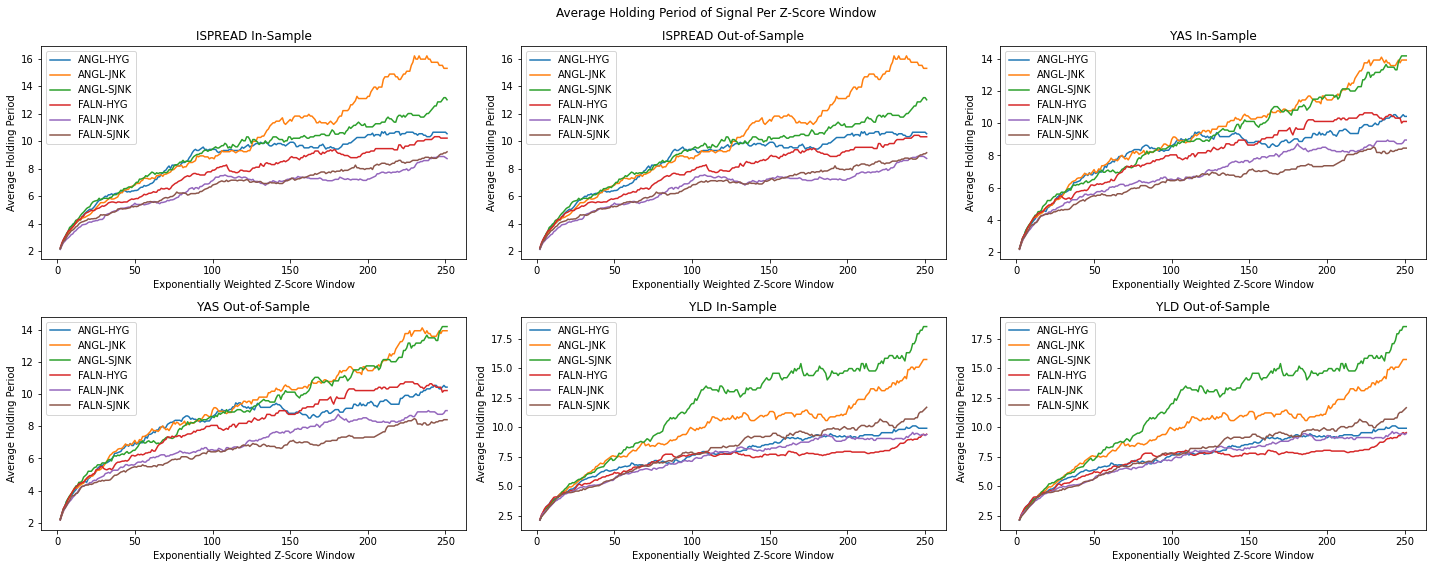

In [36]:
def plot_holding_period_window() -> plt.Figure: 
    
    df_plot = (SignalConsistancy().get_holding_period().assign(
        variable      = lambda x: np.where(x.variable == "is_signal", "In-Sample", "Out-of-Sample"),
        group_var     = lambda x: x.yld_var + " " + x.variable,
        ticker_spread = lambda x: x.ticker_spread.str.replace("_", "-")))

    group_vars = df_plot.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_plot.query(
            "group_var == @group_var").
            rename(columns = {"ticker_spread": ""}).
            pivot(index = "window", columns = "", values = "holding_period").
            plot(
                ax     = ax,
                xlabel = "Exponentially Weighted Z-Score Window",
                ylabel = "Average Holding Period",
                title  = group_var))

    fig.suptitle("Average Holding Period of Signal Per Z-Score Window")
    plt.tight_layout()
    
plot_holding_period_window() 